# Twitter: Simple  

## Summary 

### Data 
* Degree distributions 
* Activity distributions
    * Tweet
    * Favourite 
    * Follow

### Types 

#### Tweet 

* `id` $\in V \subset \mathbb{N}$            
* `user_id` $\in \mathbb{N}$         
* `retweet_status` $\in \mathbb{B}$  
* `retweeted_id` $\in \mathbb{N}$ 
* `retweeted_user_id` $\in \mathbb{N}$ 
* `content` $\in \mathbb{R}$ 
* `favorite_count` $\in \mathbb{N}$
* `retweet_count` $\in \mathbb{N}$  
* `step` $\in \mathbb{N}$        

#### User 

* `id` $\in \mathbb{N}$       
* `pos` $\in \mathbb{N}$              
* `feed` $\subset \mathcal{T}$  
* `opinion` $\in \mathbb{R}$       
* `tweet_rate` $\in \mathbb{R}$     
* `retweet_rate` $\in \mathbb{R}$     
* `favorite_rate` $\in \mathbb{R}$   
* `follow_rate` $\in \mathbb{R}$     
* `unfollow_rate` $\in \mathbb{R}$    
* `tweets` $\subset \mathcal{T}$  
* `favorites` $\subset \mathcal{T}$  

### Model 

#### Parameters

* Population size $N$
* Number of replicates $R$
* Number of time steps $T$
* Controversialness $\alpha$ 
* Follow threshold $f$
* Unfollow threshold $u$

#### Properties 

* Population size `N` 
* Time step `step` 
* Tweet ID counter `tweet_id` 
* Tweet objects `tweets` 
* Controversialness `α`
* Follow threshold `follow_threshold`
* Unfollow threshold `unfollow_threshold`

#### Initialization 

* `id` has been initialized sequentially 
* `pos` has been initialized sequentially 
* `feed` has been initialized as an empty array              
* `opinion` has been initialized as drawn from $\mathcal{U}(-1,1)$          
* `tweet_rate` and `retweet_rate` have been initialized with a sample of 2012 activity data 
* `favorite_rate` has been initialized with a sample of 2012 activity data 
* `follow_rate` and `unfollow_rate` have been initialized with a sample of 2012 activity data 
* `tweets` has been initialized as an empty array
* `favorites` has been initialized as an empty array
* `follower_graph` has been constructed such that the friends (outneighbors) of each user (node) have been drawn from a $\Gamma(2,1)$

#### Calibration 

Not discussed yet. 

#### Validation 

Not discussed yet.

#### Micro-Dynamics (`agent_step!`)

* The minimal opinion dynamics (`Update!`) follows the equation by [Baumann et al. (2020)](https://doi.org/10.1103/PhysRevLett.124.048301) 
* The minimal follow dynamics (`Follow!`) consists in a uniform sampling from the complement of set of friends according to the user's `follow_rate` and `follow_threshold` 
* The minimal unfollow dynamics (`Unollow!`) consists in a uniform sampling from the set of friends according to the user's `unfollow_rate` and `unfollow_threshold` 

#### Macro-Dynamics (`model_step!`)

* Time step `step` is incremented by one at each iteration
* Tweet ID counter `tweet_id` is incremented by one every time a tweet is authored (or retweeted)
* Tweet objects `tweets` is enriched with every tweet object authored (or retweeted)

## Thoughts & Doubts  

* How to define distinct time scales ($T_{F} \gg T_{RT} > T_{L}$)
* What about defining a status type as a reduced representation of the status object
* Choose `nsteps` taking into account the constraints induced by Monitor limits 
* Highlight the latency of the opinion variable: users do not have direct access to the *cognitive opinion* of other but they have indirect access to *behavioral opinion* leading to a non-zero (tipically high) probability of mis-interpretation (we may model it via probability distributions centered around the true value)
* Think about how to implement possibile polarization/segregation mitigation strategies (e.g. *homophily-induced heterophily*)
* Can we learn anything significant from Higgs2012 static and temporal graphs ?
* How to reliably mine temporal behavioral opinion and reaction mechanisms (e.g. net positive interaction rate: net of T,RTs,L of known polarity / total number of interactions) 

## To-Do List

* Overwrite all graph-related functions in Agents to ensure compatibility with `MultiplexGraphs.jl` (e.g. `get_node_agents()`,...)
* Think about all elementary variables, parameters and timing distributions
* Explore the portfolio of possible recommendation systems (e.g. GNN, bipartite, centrality-based, simple weighted sum,...)
* Implement basic `Follow!` and `RT!` behaviors
* Implement the simplest recommendation system (in `model_step!`)
* Implement non-trivial interpretation distribution $\rho_i$
* Explore and evaluate Higgs2012 static and temporal graph data
* Think of the best parametrization that allows effective calibration 

## Modules

In [1]:
# Basic Utilities
using Distributed, StaticArrays, SparseArrays, BenchmarkTools
# Numerical Computation
using LinearAlgebra
# Statistics 
using Random, StatsBase, Distributions
# Graphs 
using LightGraphs, SimpleWeightedGraphs, GraphPlot
# Modelling 
using Agents
# Data Wrangling 
using Queryverse, DataFrames, HTTP, CSV, DrWatson
# Data Visualization
using Plots, PlotThemes
# Python Interface 
using PyCall

# Costum Modules
MG = include("/Users/Pit/GitHub/Econophysics/Project/Models/ourModels/Pietro&Riccardo/MultiplexGraphs.jl");

## Data

### Degree

In [2]:
#py"""
#import pickle
#with open(r"/Users/Pit/GitHub/Econophysics/Project/Models/ourModels/Pietro&Riccardo/Data/degree_data.txt", "rb") as f:
#    degree_data = pickle.load(f)
#    f.close()
#"""
#degree_data = py"degree_data"

### Activity

In [ ]:
py"""
import pickle
with open(r"/Users/Pit/GitHub/Econophysics/Project/Models/ourModels/Pietro&Riccardo/Data/activity_data.txt", "rb") as f:
    activity_data = pickle.load(f)
    f.close()
"""
activity_data = py"activity_data"

## Tweet Type

In [ ]:
mutable struct Tweet
    id::Int                # tweet id
    user_id::Int           # author id
    retweet_status::Bool   # retweeet status 
    retweeted_id::Int      # retweeted tweet id 
    retweeted_user_id::Int # retweeted tweet author
    content::Real          # expressed opinion 
    favorite_count::Int    # favorite count
    retweet_count::Int     # retweet count 
    step::Int              # time step at which it's been generated
end

## Agent Type

In [ ]:
mutable struct User <: AbstractAgent
    id::Int               # idenfier code ∈ ℕ
    pos::Int              # nodal position ∈ ℕ 
    feed::Array{Tweet,1}  # tweet feed
    opinion::Real         # leaning ∈ [-1,1] 
    tweet_rate::Real      # probability to tweet its opinion 
    retweet_rate::Real    # probability to retweet a tweet
    favorite_rate::Real   # probability to like a tweet
    follow_rate::Real     # probability to follow a user
    unfollow_rate::Real   # probability to unfollow a user
    tweets::Array{Int,1}  # tweet ids history 
    favorites::Array      # liked tweet ids history
end

## Utilities

In [ ]:
function node_neighbors(agent::User, model::ABM{User,GraphSpace{Main.MultiplexGraphs.MultiplexGraph{Int64}},typeof(fastest),Dict{Symbol,Any}}, which::Symbol; neighbor_type::Symbol=:default) 
    @assert neighbor_type ∈ (:default, :in, :out)
    if neighbor_type == :default
        MG.neighbors(model.space.graph, agent.pos, which)
    elseif neighbor_type == :in
        MG.inneighbors(model.space.graph, agent.pos, which)
    elseif neighbor_type == :out
        MG.outneighbors(model.space.graph, agent.pos, which)
    end
end

# Power law sampling
function PowerlawSample(a::Real, b::Real, γ::Real)
    a + (b - a) * rand()^γ
end; ### #round(Int, PowerlawSample(1,1000,2.2))

# Hydrator 
function hydrate(id::Int, model)
    tweet=[t for t in model.tweets if t.id == id]
    return tweet[1]
end;

## Parameters

In [ ]:
# Population size
const N=1000

# Number ot time steps 
const nsteps=25

# Controversialness
α = 0.5 # parameter sensitivity [0, 0.02, 0.04, 0.06]

# Follow threshold 
follow_threshold=0.2
unfollow_threshold=0.4

# Replicates 
replicates=1;

### Initialization 

In [80]:
function InitializeModel(N::Int, α::Real, follow_threshold, unfollow_threshold)
    step=0
    tweet_id=0
    tweets=[]
    properties = @dict(N, step, tweet_id, tweets, α, follow_threshold, unfollow_threshold) # or @dict(N) where @dict is a "macro" which is equivalent to  Dict(:N => N)
    space=GraphSpace(MG.MultiplexGraph(N))
    model = ABM(User, space; properties) #AgentType, space; properties (dict)
    
    # Populate the model
    for id in 1:N
        pos = id
        feed=Array{Tweet,1}()              
        opinion=rand(Uniform(-1, 1))          
        tweet_rate=abs(round(Int, activity_data[1,id]))+1     # round(Int, rand(Gamma(3, 1))) 
        retweet_rate=abs(round(Int, activity_data[1,id]))+1   # round(Int, rand(Gamma(3, 1)))
        favorite_rate=abs(round(Int, activity_data[2,id]))+1  # round(Int, rand(Gamma(3, 1))) 
        follow_rate=abs(round(Int, activity_data[3,id]))+1    # round(Int, rand(Gamma(3, 1))) 
        unfollow_rate=abs(round(Int, activity_data[3,id]))+1  # round(Int, rand(Gamma(3, 1))) 
        tweets=Array{Int,1}()     
        favorites=Array{Int,1}()  
        add_agent!(pos, model, feed, opinion, tweet_rate, retweet_rate, favorite_rate, follow_rate, unfollow_rate, tweets, favorites) # even though opinion is optional
    end
    
    agents=[a for a in allagents(model)]
    # Initialize follower graph (static)
    for agent in agents
        others=[a for a in agents if a !=agent]
        friends=StatsBase.sample(others, round(Int, rand(Gamma(2, 1))); replace=false, ordered=false) # replace=true for favorite graph
        for friend in friends
            MG.add_edge!(model.space.graph, agent.pos, friend.pos, :follower_graph)
        end
    end
    
    return model
end

InitializeModel (generic function with 1 method)

### Macro-Dynamics

In [81]:
function model_step!(model)
    model.step+=1
end

model_step! (generic function with 1 method)

### Micro-Dynamics

#### Opinion-Dynamics Module 

In [87]:
# Opinion dynamics
function Update!(agent, model)
    friends_pos=node_neighbors(agent, model, :follower_graph, neighbor_type=:out) 
    length(friends_pos)==0 && return
    friends=[f for f ∈ allagents(model) if f.pos in friends_pos]
    opinions=[a.opinion for a in allagents(model)]
    agent.opinion = sum([(1)*tanh(model.α*friend.opinion) for friend in friends]) 
end;

#### Social-Dynamics Module 

In [88]:
# Tweet dynamics
function Tweet!(agent,model)
    agent.tweet_rate==0 && return
    for t in 1:agent.tweet_rate
        followers_pos=node_neighbors(agent, model, :follower_graph, neighbor_type=:in) 
        followers=[f for f in allagents(model) if f.pos in followers_pos]
        tweet=Tweet(model.tweet_id, agent.id, false, 0, 0, agent.opinion, 0, 0, model.step)
        for follower in followers
            push!(follower.feed, tweet)
        end 
        append!(agent.tweets, model.tweet_id)
        push!(model.tweets, tweet)
        model.tweet_id+=1
    end
end

# Like dynamics
function Like!(agent,model) 
    agent.favorite_rate==0 && return
    potential_favorites=[t for t in agent.feed if t.id ∉ agent.favorites]
    effective_favorites=StatsBase.sample(potential_favorites, min(agent.favorite_rate,length(potential_favorites)) ; replace=false, ordered=false)
    for tweet in effective_favorites
        tweet.favorite_count+=1
        append!(agent.favorites, tweet.id)
        MG.add_edge!(model.space.graph, agent.pos, tweet.user_id, :favorite_graph)
    end
end

# Retweet dyamics 
function RT!(agent,model) 
    agent.retweet_rate==0 && return
    effective_retweets=StatsBase.sample(agent.feed, min(agent.retweet_rate, length(agent.feed)); replace=false, ordered=false)
    for tweet in effective_retweets
        if tweet.retweet_status==false 
                tweet.retweet_count+=1
                MG.add_edge!(model.space.graph, agent.pos, tweet.user_id, :retweet_graph)
                
                followers_pos=node_neighbors(agent, model, :follower_graph, neighbor_type=:in) 
                followers=[f for f in allagents(model) if f.pos in followers_pos]
                retweet=Tweet(model.tweet_id, agent.id, true, tweet.id, tweet.user_id, tweet.content, 0, 0, model.step)
                for follower in followers
                    push!(follower.feed, retweet)
                end 
                append!(agent.tweets, model.tweet_id)
                push!(model.tweets, tweet)
                model.tweet_id+=1
        else
            retweet=tweet
            if retweet.user_id != agent.id
                tweet=hydrate(retweet.retweeted_id, model)
                tweet.retweet_count+=1
                MG.add_edge!(model.space.graph, agent.pos, tweet.user_id, :retweet_graph)
            
                followers_pos=node_neighbors(agent, model, :follower_graph, neighbor_type=:in) 
                followers=[f for f in allagents(model) if f.pos in followers_pos]
                for follower in followers
                    push!(follower.feed, Tweet(model.tweet_id, agent.id, true, tweet.id, tweet.user_id, tweet.content, 0, 0, model.step))
                end 
                append!(agent.tweets, model.tweet_id)
                push!(model.tweets, tweet)
                model.tweet_id+=1
            end
        end
    end
end

# Follow dynamics 
function Follow!(agent,model)
    agent.follow_rate==0 && return
    friends_pos=node_neighbors(agent, model, :follower_graph, neighbor_type=:out) 
    friends=[f for f in allagents(model) if f.pos in friends_pos]
    others=[a for a in allagents(model) if a !=agent && a ∉ friends]
    possible_friends=[other for other in others if (sign(agent.opinion)==1 && agent.opinion - model.follow_threshold ≤ other.opinion) || (sign(agent.opinion)==-1 && agent.opinion+model.follow_threshold ≥ other.opinion)]
    other_to_follow=StatsBase.sample(possible_friends, min(agent.follow_rate,length(possible_friends)) ; replace=false, ordered=false)
    for other in other_to_follow
        MG.add_edge!(model.space.graph, agent.pos, other.pos, :follower_graph)
    end
end

# Unfollow dynamics 
function Unfollow!(agent,model)
    agent.unfollow_rate==0 && return
    friends_pos=node_neighbors(agent, model, :follower_graph, neighbor_type=:out) 
    friends=[f for f in allagents(model) if f.pos in friends_pos]
    controversial_friends=[friend for friend in friends if (sign(agent.opinion)==1 && agent.opinion - model.unfollow_threshold > friend.opinion) || (sign(agent.opinion)==-1 && agent.opinion+model.unfollow_threshold < friend.opinion)]
    friends_to_unfollow = StatsBase.sample(controversial_friends, min(agent.unfollow_rate,length(controversial_friends)) ; replace=false, ordered=false)
    for friend in friends_to_unfollow
        if MG.get_weight(model.space.graph, agent.pos, friend.pos, :follower_graph) == 0 
            agent_pos=agent.pos
            friend_pos=friend.pos
            println("$agent_pos , $friend_pos")
        end
        MG.rem_edge!(model.space.graph, agent.pos, friend.pos, :follower_graph)
    end
end

# Agent dynamics
function agent_step!(agent,model)
    Tweet!(agent,model)
    #Like!(agent,model)
    #RT!(agent,model)
    Update!(agent,model)
    Follow!(agent,model)
    Unfollow!(agent,model)
end;

## Simulations 

In [89]:
model = @time InitializeModel(N, α, follow_threshold, unfollow_threshold)

###agent_data, model_data = @time run!(model, agent_step!, model_step!, nsteps, agents_first=false; 
###                                    adata = to_collect, mdata=[:geo, :contact_tracing_array],replicates=1, parallel=false); 

agent_data, _ = @time run!(model, agent_step!, model_step!, nsteps, agents_first=true; 
                           adata = [:opinion], replicates=replicates, parallel=false); 

  0.109258 seconds (51.30 k allocations: 17.932 MiB, 55.27% gc time)
 43.660853 seconds (418.16 M allocations: 12.670 GiB, 11.98% gc time)


## Visualization 

In [90]:
gd=groupby(agent_data, [:id]);

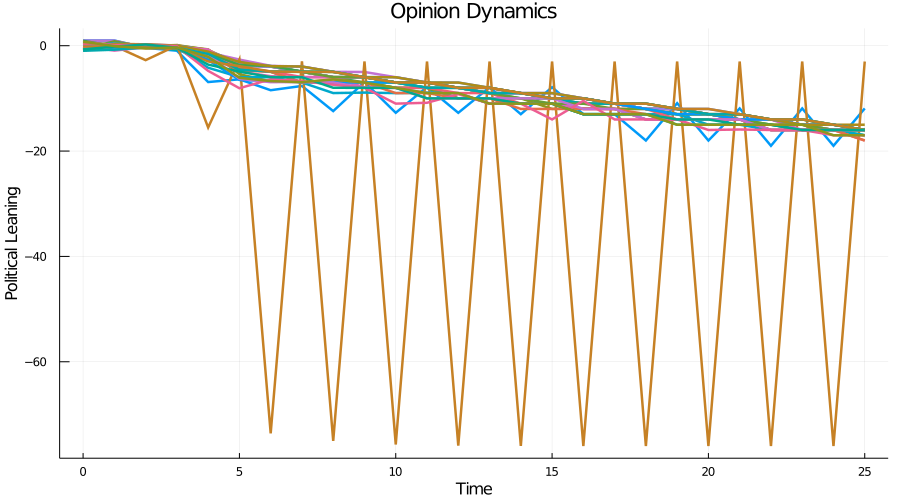

In [91]:
#timestep = 1:model.step
#timesteps=0:nsteps
#opinions=[gd[i].opinion[1] for i in timesteps]
#ft=[quantile(gd[i].tested_diagnosis-gd[i-1].tested_diagnosis,0.05) for i in timestep]
#mt=[quantile(gd[i].tested_diagnosis-gd[i-1].tested_diagnosis,0.5) for i in timestep]
#nt=[quantile(gd[i].tested_diagnosis-gd[i-1].tested_diagnosis,0.95) for i in timestep]

timesteps=[gd[i].step for i in 1:nsteps+1]
opinions=[gd[i].opinion for i in 1:nsteps+1]
plot(timesteps, opinions,
        size=(900,500),
        title="Opinion Dynamics",
        xlab="Time",
        ylabel="Political Leaning",
        legend=false,
        lw=2.5)#; ribbon=[mt-ft,nt-mt],fillalpha=0.3)

## Updates (4-10-2020)

### Activity 
* `neighbors` has been successfully implemented in `MultiplexGraphs.jl`
* `node_neighbors` compatible with `MultiplexGraphs.jl` has been successfully implemented (see *Utilities*)
* Reformed `InitializeModel` with follower graph (still random) initialization 
* Begin thinking about the portfolio of recommendation algorithms 
    * Auxiliary bipartite graph (mono or multi-edge)
    * Weighted sum over multiple edge types

## Updates (5-10-2020)

### Activity 
* Added agent attribute $\epsilon_\ell$ : the opinion distance such that if $|o_i-\rho_i(o_j)| \leq \epsilon_{L} \Rightarrow i$ likes $j$ 's tweet. As a first simple example we'll assume that $\rho_i$ is the identity such that $\rho_i(x)=x$
* Added new attributes (e.g. `attention`, `login_rate`,...)
* Created tweet type
* Implemented powerlaw sampling utility
* Initialized static follower graph, tweet histories and feeds
* Implemented a basic micro dynamics with `Tweet` and `Like!` behaviors
* Simple successful run with `N`=1000 and `nsteps`=100 with a pretty good execution time (the code is not at all optimized!)

## Updates (6-10-2020)

### Activity 
* Added new agent and tweet type attributes (e.g. `favorites`, `favorite_count`, `retweet_count`)
* Implemented `hydrate` function 
* Added new attributes to model (e.g. `tweets`: chronologically ordered archive of all tweets)
* Implemented `Read!`, `RT!` behaviors and defined `Login!` and `Logout!` behaviors
* Assumed a an order of magnitude difference between the maximum of *threshold distributions* (e.g. $\epsilon_{L}$, $\epsilon_{RT}$, $\epsilon_{F}$)
* A few corrections to previously implemented behavior functions

## Updates (7-10-2020)

### Activity 
* Simplify everything to make it possible to calibrate.

## Thoughts & Doubts  
* How to define distinct time scales ($T_{F} \gg T_{RT} > T_{L}$)
* What about defining a status type as a reduced representation of the status object
* Choose `nsteps` taking into account the constraints induced by Monitor limits 
* highlight the latency of the opinion variable: users do not have direct access to the *cognitive opinion* of other but  they have indirect access to *behavioral opinion* leading to a non-zero (tipically high) probability of mis-interpretation (we may model it via a portfolio of probability distributions centered around the true value)
* think about how to implement possibile polarization/segregation mitigation strategies (e.g. *homophily-induced heterophily*)
* Can we learn anything significant from Higgs2012 static and temporal graphs
* How to reliably mine temporal behavioral opinion and reaction mechanisms (e.g. net positive interaction rate: net of T,RTs,L of known polarity / total number of interactions) 

## To-Do List
* Overwrite all graph-related functions in Agents to ensure compatibility with `MultiplexGraphs.jl` (e.g. `get_node_agents()`,...)
* Think about all elementary variables, parameters and timing distributions
* Explore the portfolio of possible recommendation systems (e.g. GNN, bipartite, centrality-based, simple weighted sum,...)
* Implement basic `Follow!` and `RT!` behaviors
* Implement the simplest recommendation system (in `model_step!`)
* Implement non-trivial interpretation distribution $\rho_i$
* Explore and evaluate Higgs2012 static and temporal graph data
* Think of the best parametrization that allows effective calibration 